## Marketing insight in Burger King / McDonalds locations

#### Version
- 03-08-2019 /  Léon Smiers, Consolidated version 

#### Introduction
As part of the Marketing class as part of the __[RSM OneMBA](https://www.rsm.nl/mba/global-executive-onemba)__ curriculum I investigate the marketing mix 4P's (Product, Price, Promotion and Place) for Burger King. Here I specifically look at the PLACE aspect of marketing. Using Google APIs and Random Forests delivers insight in what features determine the choice of a Burger King for a specific location in The Netherlands.

#### This Notebook
In this notebook I investigate the classification of a Burger King location. The technique used over here is based upon Random Forest. 
This notebook relates to the "Burger King locations.ipynb" Jupyter notebook.

#### Features 
For the "Place" I used Google APIs to find Burger King (and McDonalds) location including 13 features 
- Shopping nearby
  - Shopping Mall / Shops 
- Travel proximity
  - Subway station  / Train station / Metro / Airport / Gas station 
- Restaurant proximity
  - McD / KFC / Subway / Five Guys
  - Other restaurants nearby (amount)
- All proximity checks are within 500 meter
- One exception gas station within 300 meters


In [1]:
from sklearn.ensemble import RandomForestClassifier
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
#Init
column_names = ['number_of_closeby_restaurants', 'number_of_closeby_takeaways',
       'BK_nearby','Five_Guys_nearby','KFC_nearby','McDonalds_nearby','Subway_nearby',
       'shopping_mall_nearby',
       'airport_nearby','gas_station_nearby','subway_station_nearby','train_station_nearby',
       'number_of_closeby_stores']

In [3]:
def create_noise(num_rows, column_names):
    """ create noise for 13 features
        number_of_closeby_restaurants, number_of_closeby_takeaways [0-20]
        BK_nearby,Five_Guys_nearby,KFC_nearby,McDonalds_nearby,Subway_nearby [0-1]
        shopping_mall_nearby,airport_nearby,gas_station_nearby,subway_station_nearby,train_station_nearby [0-1]
        number_of_closeby_stores [0-20]
    Input : number of rows int
            column_name list 
    Output : df_noise dataframe
    Used libs : Pandas   """    
    logging.info("num_rows: {0} ".format(num_rows))
    logging.info("len column_names: {0}".format(len(column_names)))
    #Make noise number_of_closeby_restaurants / number_of_closeby_takeaways
    #Both 0-20
    x_noise_1=np.random.randint(21, size=(num_rows, 1))
    x_noise_2=np.random.randint(21, size=(num_rows, 1))
    x_noise_compound=np.append(x_noise_1, x_noise_2, axis=1)
    
    #Make noise 'nearby' fesatures, all 0-1
    #Two companies are investigated, BK and McD. Nearby features for these are removed in handling
    #When handling BK, BK_nearby is removed
    #When handling McD, McDonalds_nearby is removed 
    x_noise_3=np.random.randint(2, size=(num_rows, 9))
    x_noise_compound=np.append(x_noise_compound, x_noise_3, axis=1)

    #Make noise number_of_closeby_stores 0-20
    x_noise_4=np.random.randint(21, size=(num_rows, 1))
    x_noise_compound=np.append(x_noise_compound, x_noise_4, axis=1)
    
    logging.info("x_noise_compound: {0}".format(x_noise_compound.shape))

    df_noise = pd.DataFrame(x_noise_compound,columns=column_names)
    
    return df_noise

#create_noise(4)

In [4]:
def execute_randomforest(df_x_values, df_y_values,feature_names, company):
    """ Build a classification task using company data
        Half of the input should be actual data, other half should noise
    Input : df_x_values  df dataframe containing features
            df_y_values  1-dimensional dataframe containing 1 (actual measurement row) or 0 (noise row)
            feature_names list of feature_names
    Output : print of classification which feature the most important
    Used libs : Pandas   """    

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    x_scores=df_x_values.values
#    forest.fit(x_scores, num_y_scores.ravel())
    forest.fit(x_scores, df_y_values.values.ravel())
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    #print(indices)
    #print("indices")

    # Print the feature ranking
    #print("Feature ranking:")

    ordered_names = []
    for f in range(df_x_values.values.shape[1]):
        #print("f: {0}".format(f))
        #print(feature_names[indices[f]])
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        ordered_names.append(feature_names[indices[f]])
        #print("%d. feature %d (%f)" % (f + 1, ordered_names[f], importances[indices[f]]))
    #print(ordered_names)

    # Plot the feature importances of the forest
    plt.figure(figsize=(15, 10))
    title="Feature importances"
    if company=="BK":
        title=title+" Burger King"
    else:
        title=title+" McDonalds"
        
    plt.title(title,fontsize=18)
    plt.bar(range(x_scores.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
#    plt.xticks(range(X.shape[1]), indices)
    plt.xticks(range(x_scores.shape[1]), ordered_names,rotation='vertical', fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim([-1, x_scores.shape[1]])
    plt.show()

INFO:root:num_rows: 66 
INFO:root:len column_names: 12
INFO:root:x_noise_compound: (66, 12)


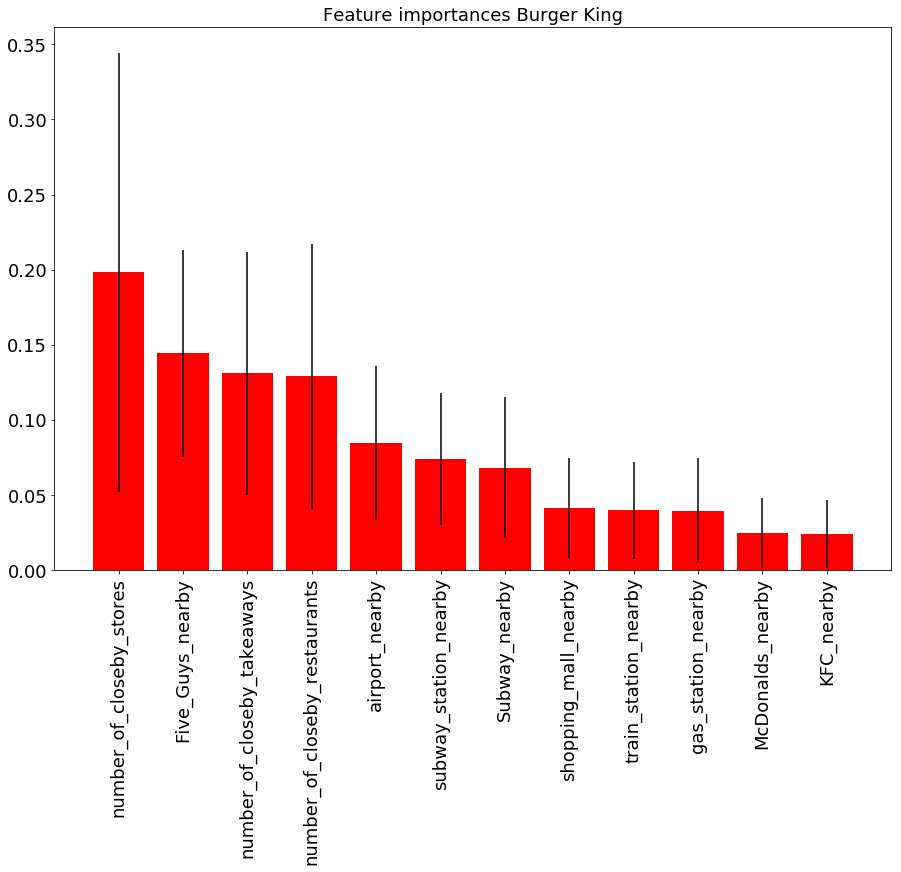

INFO:root:num_rows: 186 
INFO:root:len column_names: 12
INFO:root:x_noise_compound: (186, 12)


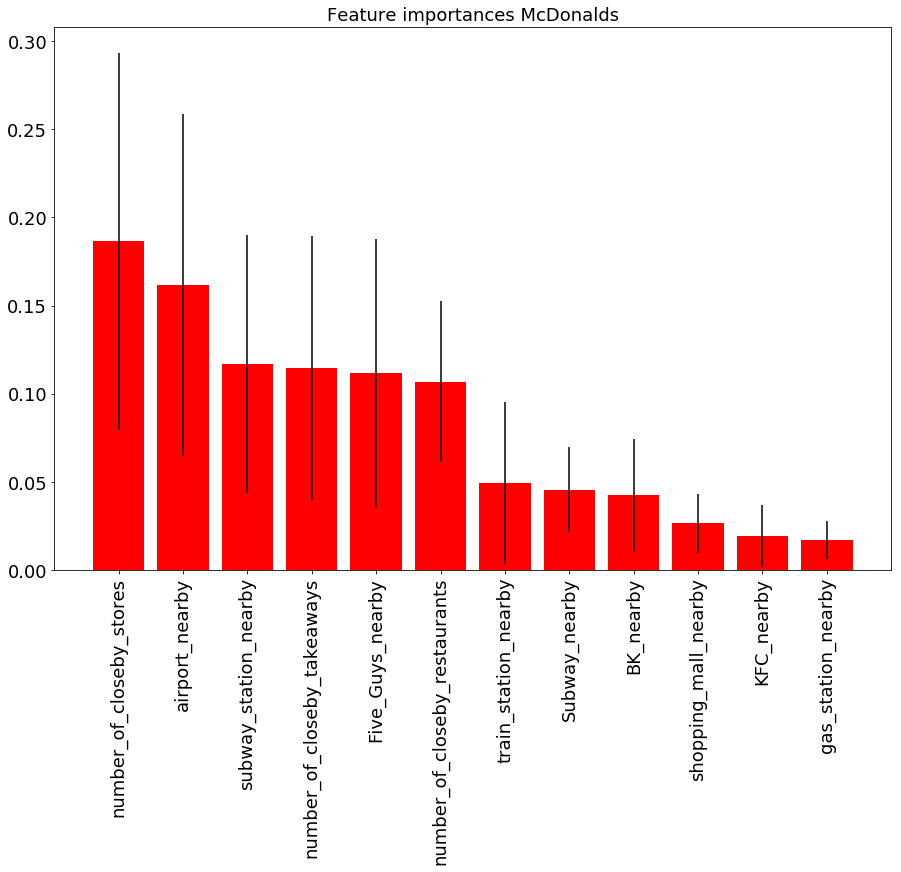

In [5]:
def handle_company(company):
    """ Handle company Burger King or Mc Donals
    Input : df_x_values  df dataframe containing features
            company BK or McD
    Output : print of classification which feature the most important
    Used libs : Pandas   """    

    if company == "BK":
        #Burger King
        #read scores for features
        df_x_scores = pd.read_excel('X-scores-BK.xlsx')
        df_x_scores.drop(['BK_nearby'], axis=1, inplace=True)
        
        #Remove BK from list (for BK only contains value 1)
        column_names_company = list(column_names)
        column_names_company.remove('BK_nearby')
    else:
        #Mc Donalds
        #read scores for features
        df_x_scores = pd.read_excel('X-scores-McD.xlsx')
        df_x_scores.drop(['McDonalds_nearby'], axis=1, inplace=True)
        
        #Remove BK from list (for BK only contains value 1)
        column_names_company = list(column_names)
        column_names_company.remove('McDonalds_nearby')

    #Put result in DataFrame
    x_scores=df_x_scores.values
    df_x_scores.shape
    
    #Create noise
    #print(x_scores.shape[0])
    df_noise=create_noise(df_x_scores.values.shape[0],column_names_company)
    df_noise.shape
    
    #Add noise to actual values
    df_x_scores=df_x_scores.append(df_noise,sort=False)
    #print(df_x_bk_scores.shape)
    #print(np.isnan(df_x_scores.values).any())
    df_x_scores.shape
    
    #Fill scores for randomforest
    np_ones=np.ones(x_scores.shape[0])
    np_zeros=np.zeros(x_scores.shape[0])
    y_scores=np.append(np_ones, np_zeros)
    df_y_scores=pd.DataFrame(y_scores)
    df_y_scores.shape
    #print(np.isnan(df_y_scores.values).any())
    
    #Determine classifications and create plots
    execute_randomforest(df_x_scores, df_y_scores,column_names_company, company)

handle_company('BK')
handle_company('McD')